<a href="https://colab.research.google.com/github/iammuhammad41/Autoencoders-for-Anomaly-Detection/blob/main/autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math, re, os, cv2
import random
import gc
from tqdm import tqdm
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from skimage.util import random_noise
from skimage.transform import rotate, AffineTransform, warp

Tensorflow version 2.2.0


In [ ]:
#Path of cloud and Non-cloud datasets
path = '../input/cloud-anomaly-detection-images/noncloud/noncloud'
path2 = '../input/cloud-anomaly-detection-images/cloud/cloud'

In [ ]:
#Loaded and Preprocessed all the non-cloud satellite images for training
all_images=[]
import os
img_list = os.listdir(path)
for i in tqdm(img_list):
    img = tf.keras.preprocessing.image.load_img(path+'/'+str(i), target_size=(384,384,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255.
    all_images.append(img)

all_images= np.array(all_images[1:])
all_images.shape

100%|██████████| 1500/1500 [00:09<00:00, 161.38it/s]


(1499, 384, 384, 3)

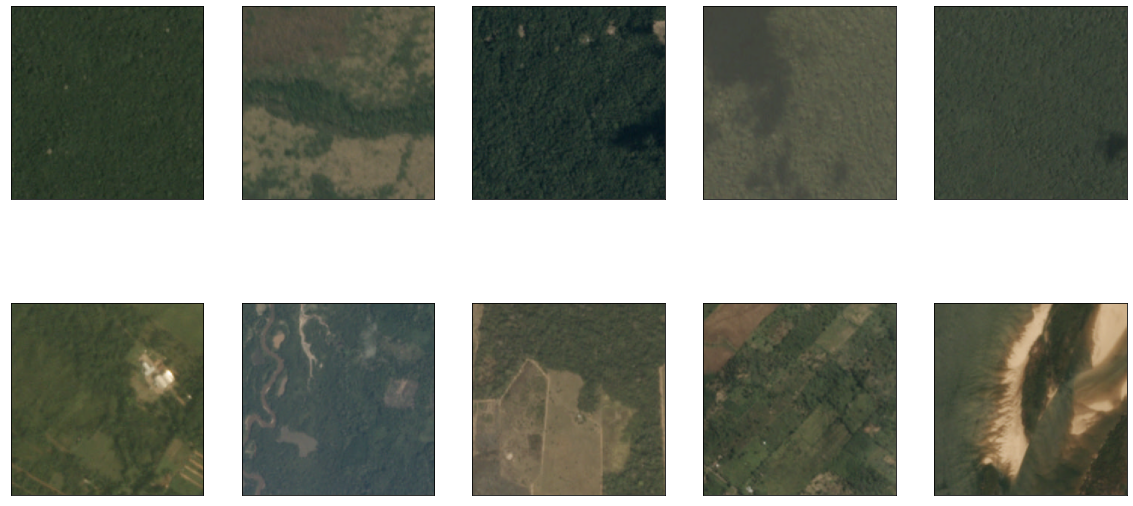

In [ ]:
#Show non-cloud images
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(all_images[i+50])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(all_images[i+20])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
def anticlockwise_rotation(image):
    angle= random.randint(0,180)
    return rotate(image, angle)

def clockwise_rotation(image):
    angle= random.randint(0,180)
    return rotate(image, -angle)

def h_flip(image):
    return  np.fliplr(image)

def v_flip(image):
    return np.flipud(image)

def add_noise(image):
    return random_noise(image)

def blur_image(image):
    return cv2.GaussianBlur(img, (9,9),0)


#classifying blur and non-blur images
def warp_shift(image):
    transform = AffineTransform(translation=(0,40))  #chose x,y values according to your convinience
    warp_image = warp(image, transform, mode="wrap")
    return warp_image




In [ ]:
# hyperparameters
IMAGE_SIZE = [384,384]
SEED = 42
n_hidden_1 = 512
n_hidden_2 = 256
n_hidden_3 = 64
n_hidden_4 = 16
n_hidden_5 = 8
convkernel = (3, 3)
poolkernel = (2, 2)

In [ ]:
#seeds
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)


Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [ ]:
def get_model():
    K.clear_session()
    with strategy.scope():
        inp1 = tf.keras.layers.Input(shape = (*IMAGE_SIZE, 3))

        x = tf.keras.layers.Conv2D(n_hidden_1, convkernel, activation='relu', padding='same')(inp1)
        x = tf.keras.layers.Conv2D(n_hidden_1, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)#

        x = tf.keras.layers.Conv2D(n_hidden_2, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_2, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)#

        x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)#

        x = tf.keras.layers.Conv2D(n_hidden_4, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_4, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_4, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_4, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)#

        x = tf.keras.layers.Conv2D(n_hidden_5, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_5, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_5, convkernel, activation='relu', padding='same')(x)
        encoded = tf.keras.layers.Conv2D(n_hidden_5, convkernel, activation='relu', padding='same')(x)


        #decoder
        x = tf.keras.layers.Conv2DTranspose(n_hidden_5, convkernel, strides=2, activation='relu', padding='same')(encoded)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_4, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_3, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_2, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_1, convkernel, strides=1, activation='relu', padding='same')(x)

        decoded = tf.keras.layers.Conv2DTranspose(3, convkernel, activation="sigmoid", padding='same')(x)

        model = tf.keras.models.Model(inputs = inp1, outputs = decoded)

        opt = tfa.optimizers.RectifiedAdam(lr=3e-4)
        model.compile(
            optimizer = opt,
            loss = 'mse',
            metrics = [tf.keras.metrics.RootMeanSquaredError()]
        )

        return model

In [ ]:
def get_vgg19():
    K.clear_session()
    with strategy.scope():
        image_input = tf.keras.layers.Input(shape = (*IMAGE_SIZE,3))
        vg19 = tf.keras.applications.VGG19(input_tensor = image_input, weights = 'imagenet', include_top=False)
        encoded = vg19.get_layer('block5_pool').output
        #decode
        x = tf.keras.layers.Conv2DTranspose(n_hidden_5, convkernel, strides=2, activation='relu', padding='same')(encoded)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_4, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_3, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_2, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_1, convkernel, strides=2, activation='relu', padding='same')(x)
        decoded = tf.keras.layers.Conv2DTranspose(3, convkernel, activation="sigmoid", padding='same')(x)
        model = tf.keras.models.Model(inputs = image_input, outputs = decoded)
        opt = tfa.optimizers.RectifiedAdam(lr=3e-4)
        model.compile(
            optimizer = opt,
            loss = 'mse',
            metrics = [tf.keras.metrics.RootMeanSquaredError()]
        )
        return model

In [ ]:

model=  get_vgg19() #get_model()
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 384, 384, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 384, 384, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 384, 384, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 192, 192, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 192, 192, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 192, 192, 128)     147584    
______________________________________________________________

In [ ]:
#Split the dataset into train and test with a ratio of 80:20.
X_train, X_test = train_test_split(all_images, test_size=0.2, random_state=SEED)
print(X_train.shape, X_test.shape)

(1199, 384, 384, 3) (300, 384, 384, 3)


In [ ]:
del all_images;  gc.collect()

226

In [ ]:
#model training config params
EPOCHS = 100
BATCH_SIZE = 16
NUM_TRAINING_IMAGES = X_train.shape[0]
steps = NUM_TRAINING_IMAGES // BATCH_SIZE
NUM_VALID_IMAGES = X_test.shape[0]
val_steps = NUM_VALID_IMAGES // BATCH_SIZE

In [ ]:
#Model training
sav = tf.keras.callbacks.ModelCheckpoint(

    'Enc'+'.h5', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='min', save_freq='epoch')
# lr scheduler
cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4, patience = 2,
                                                      verbose = 1, mode = 'min',min_delta = 0.0001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5,
                                                  verbose = 1, min_delta = 0.0001)
model.fit(X_train, X_train,
      validation_data=(X_test, X_test),
      steps_per_epoch=steps,
      validation_steps=val_steps,
      epochs = EPOCHS,
      callbacks= [sav, cb_lr_schedule,early_stopping],
      verbose = 1)

Epoch 1/100
74/74 [==============================] - ETA: 0s - loss: 0.0330 - root_mean_squared_error: 0.1817
Epoch 00001: val_loss improved from inf to 0.00702, saving model to Enc.h5
74/74 [==============================] - 41s 552ms/step - loss: 0.0330 - root_mean_squared_error: 0.1817 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0838 - lr: 3.0000e-04
Epoch 2/100
74/74 [==============================] - ETA: 0s - loss: 0.0037 - root_mean_squared_error: 0.0612
Epoch 00002: val_loss improved from 0.00702 to 0.00271, saving model to Enc.h5
74/74 [==============================] - 16s 212ms/step - loss: 0.0037 - root_mean_squared_error: 0.0612 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0521 - lr: 3.0000e-04
Epoch 3/100
74/74 [==============================] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0470
Epoch 00003: val_loss improved from 0.00271 to 0.00238, saving model to Enc.h5
74/74 [==============================] - 16s 212ms/step - loss: 0.0022 - root_m